In [1]:
%matplotlib inline

In [2]:
import sklearn
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree

import graphviz
import pandas as pd
from dtreeviz import trees

# Set up the dataset

In [3]:
random_state = 1234
dataset = pd.read_csv("../data/titanic/titanic.csv")
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

# Set up the pipeline

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [5]:
model = make_pipeline(
    VarianceThreshold(0.5),
    PolynomialFeatures(degree=2, interaction_only=True),
    DecisionTreeClassifier(max_depth=4))

In [6]:
model.fit(dataset[features], dataset[target])

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.5)),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4))])

### Extract relevant parameters for `dtreeviz` from the pipeline


As the model used has several preprocessing steps prior the decision tree, its feature space is different from `dataset[features]`. Hence, we first have to extract the relevant parameters from the pipeline before passing them to `dtreeviz`. Here, we use the following helper function from the `dtreeviz.utils` module:

In [7]:
from dtreeviz.utils import extract_params_from_pipeline

In [8]:
tree_classifier, x_data, features_model = extract_params_from_pipeline(
    pipeline=model,
    x_data=dataset[features],
    feature_names=features)

In [9]:
y_data = dataset[target]

In [10]:
features_model

['1',
 'Pclass',
 'Age',
 'Fare',
 'Cabin_label',
 'Embarked_label',
 'Pclass Age',
 'Pclass Fare',
 'Pclass Cabin_label',
 'Pclass Embarked_label',
 'Age Fare',
 'Age Cabin_label',
 'Age Embarked_label',
 'Fare Cabin_label',
 'Fare Embarked_label',
 'Cabin_label Embarked_label']

## Initialize shadow tree

In [11]:
sk_dtree = ShadowSKDTree(tree_classifier, x_data, y_data, features_model, target, [0, 1])

## Visualizations

### viz_leaf_samples

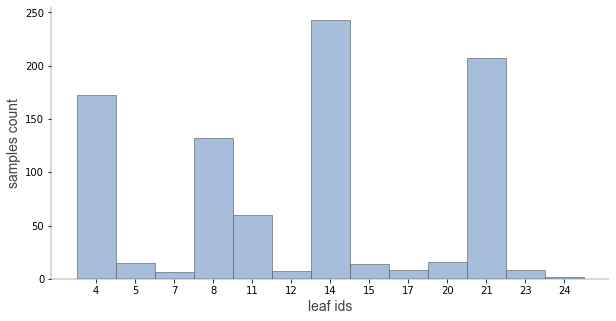

In [12]:
trees.viz_leaf_samples(tree_classifier, x_data, features)

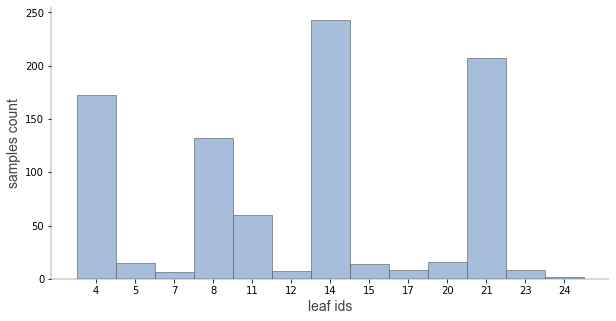

In [13]:
trees.viz_leaf_samples(sk_dtree)

### ctreeviz_leaf_samples

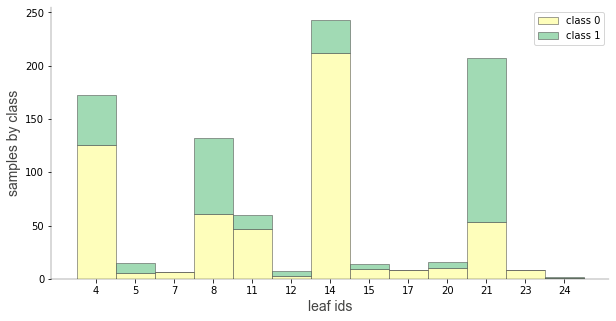

In [14]:
trees.ctreeviz_leaf_samples(tree_classifier, x_data, y_data, features)

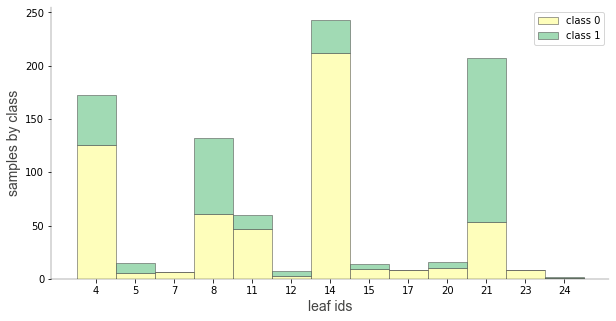

In [15]:
trees.ctreeviz_leaf_samples(sk_dtree)

### dtreeviz

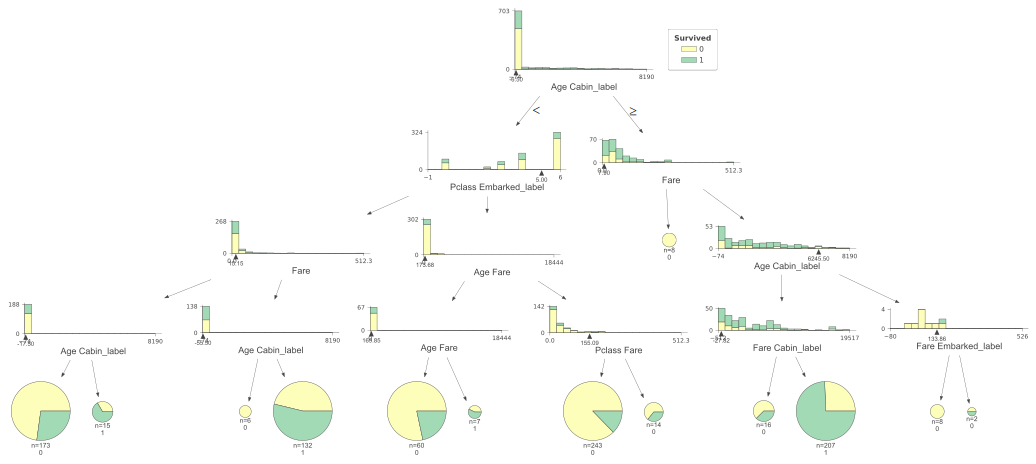

In [16]:
trees.dtreeviz(tree_classifier, x_data, y_data, features_model, target, class_names=[0, 1])

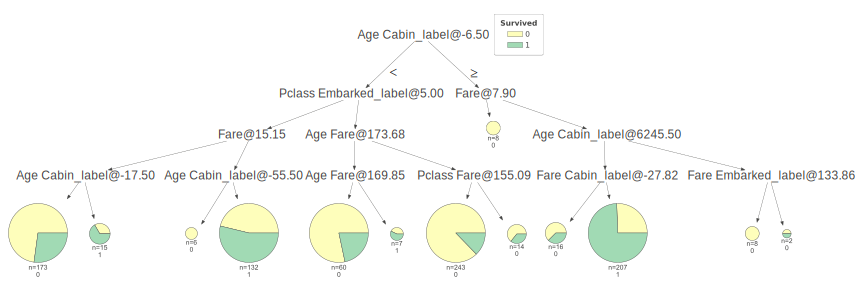

In [17]:
trees.dtreeviz(sk_dtree, fancy=False)

#### show just path

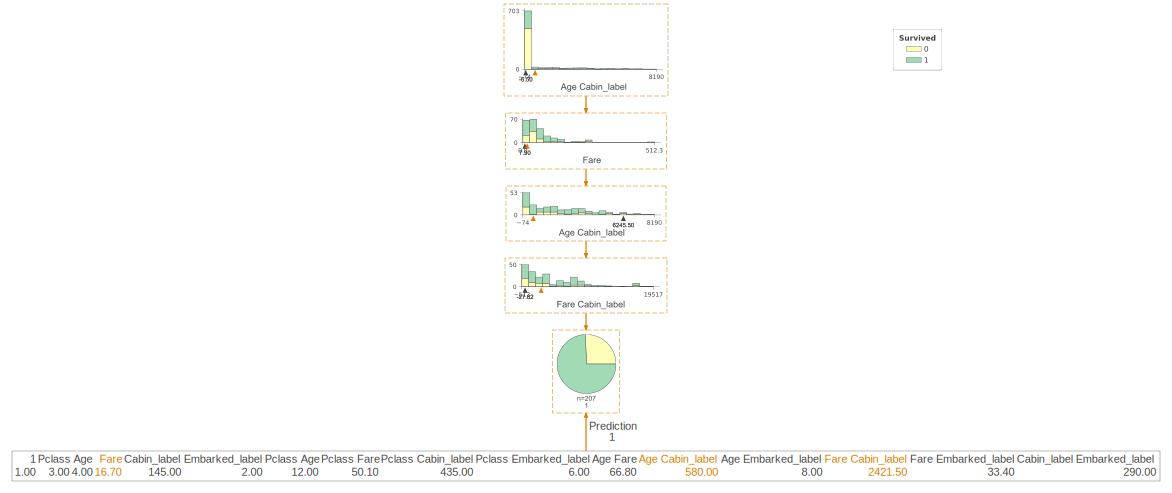

In [18]:
trees.dtreeviz(sk_dtree, show_just_path=True, X = x_data.iloc[10])

### viz_leaf_criterion

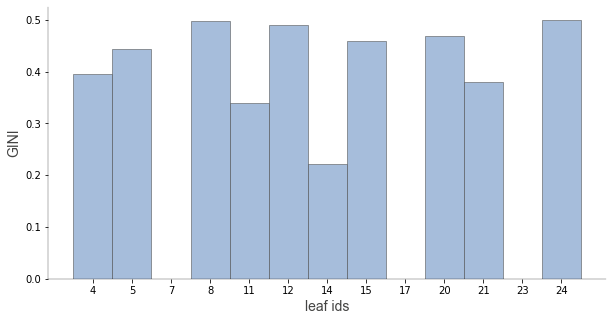

In [19]:
trees.viz_leaf_criterion(tree_classifier)

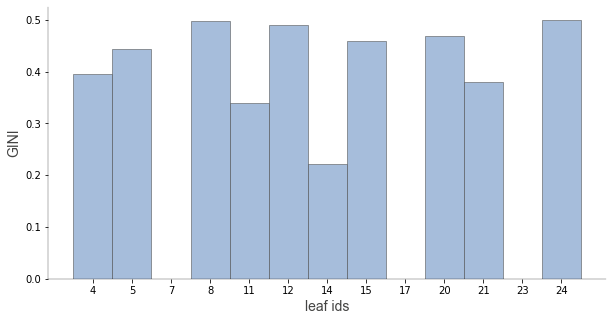

In [20]:
trees.viz_leaf_criterion(sk_dtree)

### describe_node_sample

In [21]:
trees.describe_node_sample(tree_classifier, node_id=10, x_data=x_data, feature_names=features_model)


,1,Pclass,Age,Fare,Cabin_label,Embarked_label,Pclass Age,Pclass Fare,Pclass Cabin_label,Pclass Embarked_label,Age Fare,Age Cabin_label,Age Embarked_label,Fare Cabin_label,Fare Embarked_label,Cabin_label Embarked_label
count,67.0,67.0,67.000000,67.000000,67.0,67.0,67.000000,67.000000,67.0,67.0,67.000000,67.000000,67.000000,67.000000,67.000000,67.0
mean,1.0,3.0,19.902985,7.697699,-1.0,2.0,59.708955,23.093096,-3.0,6.0,143.276728,-19.902985,39.805970,-7.697699,15.395397,-2.0
std,0.0,0.0,5.064163,2.761536,0.0,0.0,15.192489,8.284607,0.0,0.0,39.271248,5.064163,10.128326,2.761536,5.523071,0.0
min,1.0,3.0,8.000000,0.000000,-1.0,2.0,24.000000,0.000000,-3.0,6.0,0.000000,-49.000000,16.000000,-21.075000,0.000000,-2.0
25%,1.0,3.0,18.000000,7.372900,-1.0,2.0,54.000000,22.118700,-3.0,6.0,140.662200,-21.000000,36.000000,-8.050000,14.745800,-2.0
50%,1.0,3.0,20.000000,7.854200,-1.0,2.0,60.000000,23.562600,-3.0,6.0,152.250000,-20.000000,40.000000,-7.854200,15.708400,-2.0
75%,1.0,3.0,21.000000,8.050000,-1.0,2.0,63.000000,24.150000,-3.0,6.0,163.755900,-18.000000,42.000000,-7.372900,16.100000,-2.0
max,1.0,3.0,49.000000,21.075000,-1.0,2.0,147.000000,63.225000,-3.0,6.0,173.650000,-8.000000,98.000000,-0.000000,42.150000,-2.0


In [22]:
trees.describe_node_sample(sk_dtree, node_id=10)

,1,Pclass,Age,Fare,Cabin_label,Embarked_label,Pclass Age,Pclass Fare,Pclass Cabin_label,Pclass Embarked_label,Age Fare,Age Cabin_label,Age Embarked_label,Fare Cabin_label,Fare Embarked_label,Cabin_label Embarked_label
count,67.0,67.0,67.000000,67.000000,67.0,67.0,67.000000,67.000000,67.0,67.0,67.000000,67.000000,67.000000,67.000000,67.000000,67.0
mean,1.0,3.0,19.902985,7.697699,-1.0,2.0,59.708955,23.093096,-3.0,6.0,143.276728,-19.902985,39.805970,-7.697699,15.395397,-2.0
std,0.0,0.0,5.064163,2.761536,0.0,0.0,15.192489,8.284607,0.0,0.0,39.271248,5.064163,10.128326,2.761536,5.523071,0.0
min,1.0,3.0,8.000000,0.000000,-1.0,2.0,24.000000,0.000000,-3.0,6.0,0.000000,-49.000000,16.000000,-21.075000,0.000000,-2.0
25%,1.0,3.0,18.000000,7.372900,-1.0,2.0,54.000000,22.118700,-3.0,6.0,140.662200,-21.000000,36.000000,-8.050000,14.745800,-2.0
50%,1.0,3.0,20.000000,7.854200,-1.0,2.0,60.000000,23.562600,-3.0,6.0,152.250000,-20.000000,40.000000,-7.854200,15.708400,-2.0
75%,1.0,3.0,21.000000,8.050000,-1.0,2.0,63.000000,24.150000,-3.0,6.0,163.755900,-18.000000,42.000000,-7.372900,16.100000,-2.0
max,1.0,3.0,49.000000,21.075000,-1.0,2.0,147.000000,63.225000,-3.0,6.0,173.650000,-8.000000,98.000000,-0.000000,42.150000,-2.0
